In [1]:
## Version 21

In [2]:
import os
import numpy as np
import tensorflow as tf
import keras
from skimage.io import imread
from skimage.transform import resize
from  tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model
from matplotlib.pyplot import imsave,imshow
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import random
from scipy import ndarray
from skimage import transform
from skimage import util

Using TensorFlow backend.


In [1]:
PATH = 'INSERT TRAIN PATH'
TEST_PATH = 'INSERT OUTPUT PATH'
OUTPUT_PATH ='INSERT OUTPUT PATH'

# Image resizing parameters
HEIGHT = 128
WIDTH = 128
CHANNELS = 3

In [4]:
def imageProcessingModule():
    """
    Function to read training images and corresponding masks and 
    resize to a particular dimension. The resized images will be stored
    numpy arrays
    
    Parameters
    ----------
    None
    
    Returns
    -------
    raw_data : numpy array of raw images
    mask_data : numpy array of mask images
    
    """
    raw_files = os.listdir(PATH+'raw/')
    msk_files = os.listdir(PATH+'gt/')

    raw_data = np.zeros((len(raw_files), HEIGHT, WIDTH, CHANNELS), dtype=np.float_)
    mask_data = np.zeros((len(raw_files), HEIGHT, WIDTH, 1), dtype=np.bool)
    index = 0
    for file in raw_files:
        if (file in msk_files):
            raw_img = imread(PATH +'raw/'+ file)
            raw_img = resize(raw_img, (HEIGHT, WIDTH), anti_aliasing=True)
            mask = np.zeros((HEIGHT, WIDTH, 1), dtype=np.bool)
            msk_img = imread(PATH +'gt/'+ file)
            msk_img = np.expand_dims(resize(msk_img, (HEIGHT, WIDTH),
                                          anti_aliasing=True), axis=-1)
            mask = np.maximum(mask, msk_img)
            raw_data[index] = raw_img
            mask_data[index] = mask
            index=index+1
    return raw_data,mask_data

In [5]:
def data_generator(x_train, y_train, batch_size):
    """
    Function to implement data augmentation
    
    Parameters
    ----------
    x_train : numpy array of raw images
    y_train : numpy array of mask images
    batch_size : integer value that specifies batch size 
    
    Returns
    -------
    x_batch, y_bathc : Image Generators
    
    """
    data_gen_args = dict(width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10,
            zoom_range = 0.1)
    
    image_generator = ImageDataGenerator(**data_gen_args).flow(x_train, x_train, batch_size, seed = 42)
    mask_generator = ImageDataGenerator(**data_gen_args).flow(y_train, y_train, batch_size, seed = 42)
    while True:
        x_batch, _ = image_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [6]:
# Code from https://www.kaggle.com/toregil/a-lung-u-net-in-keras In[7]
def dice_coef(y_true, y_pred):
    """
    Function to calculate dice coefficient
    
    Parameters
    ----------
    y_true : numpy array of actual masks
    y_pred : numpy array of predicted masks
    
    Returns
    -------
    dice coefficient
    
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [7]:
def modelBuilder(x_train, x_val, y_train, y_val):
    """
    Function to build and train the UNet model
    
    Parameters
    ----------
    x_train : numpy array of training images
    y_train : numpy array of training masks
    x_val : numpy array of validation images
    y_val : numpy array of validation masks
    
    Returns
    -------
    model : Trained model
    results : Dictionary of model metrics
    
    """
    print ('Building U-Net...')
    inputs = tf.keras.layers.Input((HEIGHT, WIDTH, CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(s)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv5)

    upconv6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    upconv6 = tf.keras.layers.concatenate([upconv6, conv4])
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv6)

    upconv7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upconv7 = tf.keras.layers.concatenate([upconv7, conv3])
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv7)

    upconv8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    upconv8 = tf.keras.layers.concatenate([upconv8, conv2])
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv8)

    upconv9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    upconv9 = tf.keras.layers.concatenate([upconv9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef,'accuracy'])
    model.summary()
    callbacks = [EarlyStopping(patience=6, monitor='val_loss')]
 
    results = model.fit_generator(data_generator(x_train,y_train,8),
                                  steps_per_epoch = 200,
                                  validation_data = (x_val,y_val),
                                  epochs=20,callbacks=callbacks)
 
    model.save('nuclei_segmentation_v1.h5')
    return model, results

In [8]:
def testingModule():
    """
    Function to load model and feed test images. The predictions
    will be saved as npz files and pickle file
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    
    """
    print('Generating mask for test data...')
    test_raw = os.listdir(TEST_PATH)
    output_msk = np.zeros((len(test_raw), HEIGHT, WIDTH), dtype=np.uint8)
    output_msk_file = []
    output_msk_dim ={}
    idx = 0
    for file in test_raw:
        test_img = imread(TEST_PATH + file)
        org_shpe_array = np.asarray(test_img.shape)
        test_img = resize(test_img, (HEIGHT, WIDTH), anti_aliasing=True)
        xtest = np.array(test_img)
        xtest=np.expand_dims(xtest, axis=0)
        pred = model.predict(xtest)
        pred = (pred > 0.75).astype(np.uint8)
        pred = np.squeeze(pred[0])
        
        output_msk[idx]=pred
        output_msk_file.insert(idx, file)
        idx+=1
        output_msk_dim.setdefault(file,[]) 
        output_msk_dim[file].append(org_shpe_array[0])
        output_msk_dim[file].append(org_shpe_array[1])

    
    #imshow(pred)
    np.savez("mask_image_array", output_msk)
    np.savez("mask_image_labels", output_msk_file)
    with open('mask_image_dim.pickle', 'wb') as handle:
        pickle.dump(output_msk_dim, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    postProcessing("mask_image_array.npz","mask_image_labels.npz","mask_image_dim.pickle")

In [9]:
def postProcessing(X,Y,Z):
    """
    Function to load data and generate masks according to initial test image size
    
    Parameters
    ----------
    X : String. Filename of mask image array
    Y : String. Filename of mask image filename
    Z : String. Filename of mask image dimensions
    
    Returns
    -------
    None
    
    """
    print ('Resizing generated masks to actual dimensions...')
    x_npz = np.load(X)
    y_npz = np.load(Y)
    with open(Z, 'rb') as handle:
        mask_image_dim_dict = pickle.load(handle)
    
    mask_array = x_npz['arr_0']
    mask_label = y_npz['arr_0']
    
    for row in range(0,len(mask_array)):
        height_ = mask_image_dim_dict[mask_label[row]][0]
        width_ = mask_image_dim_dict[mask_label[row]][1]
        img = resize(mask_array[row], (height_, width_), anti_aliasing=True) #resizing image to initial size
        imsave(OUTPUT_PATH + mask_label[row], img, cmap = 'gray')
    print ('Complete...')

In [10]:
def plot_model_history(history):
    """
    Function to plot training and validation data of model
    
    Parameters
    ----------
    history: dictionary
             history of training and validation of model
    Returns
    -------
    None
    
    """
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice coefficient')
    plt.ylabel('dice_coefficient')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [11]:
def validationImageChecker(xval,yval):
    """
    Function to generate masks for validation images plot it against the
    corresponding ground truth masks
    
    Parameters
    ----------
    xval : numpy array of validation images
    yval : numpy array of validation masks
    
    Returns
    -------
    None
    
    """
    output_msk = np.zeros((len(xval), HEIGHT, WIDTH), dtype=np.uint8)
    idx = 0
    for im in xval:
        xtest = np.array(im)
        xtest=np.expand_dims(xtest, axis=0)
        pred = model.predict(xtest)
        pred = (pred > 0.55).astype(np.uint8)
        pred = np.squeeze(pred[0])
        output_msk[idx]=pred
        idx+=1
    fix, ax = plt.subplots(5,2, figsize=(8,20))
    for i in range(5):
        ax[i,0].set_title(' Actual Mask')
        ax[i,0].imshow(yval[i,:,:,0])
        ax[i,1].set_title('Predicted Mask')
        ax[i,1].imshow(output_msk[i],cmap='gray')
    plt.show()

In [12]:
def augmentedImageChecker(x_train, y_train, seed):
    """
    Function to generate images of augmented training images and masks
    
    Parameters
    ----------
    x_train : numpy array of augmented training images
    y_train : numpy array of augmented training masks
    seed : integer value
    
    Returns
    -------
    None
    
    """
    raw_batch, mask_batch = next(data_generator(x_train, y_train, seed))
    fix, ax = plt.subplots(5,2, figsize=(8,20))
    for i in range(5):
        ax[i,0].set_title('Augmented Train Image')
        ax[i,0].imshow(raw_batch[i,:,:,0])
        ax[i,1].set_title('Augmented Train Mask')
        ax[i,1].imshow(mask_batch[i,:,:,0],cmap='gray')
    plt.show()

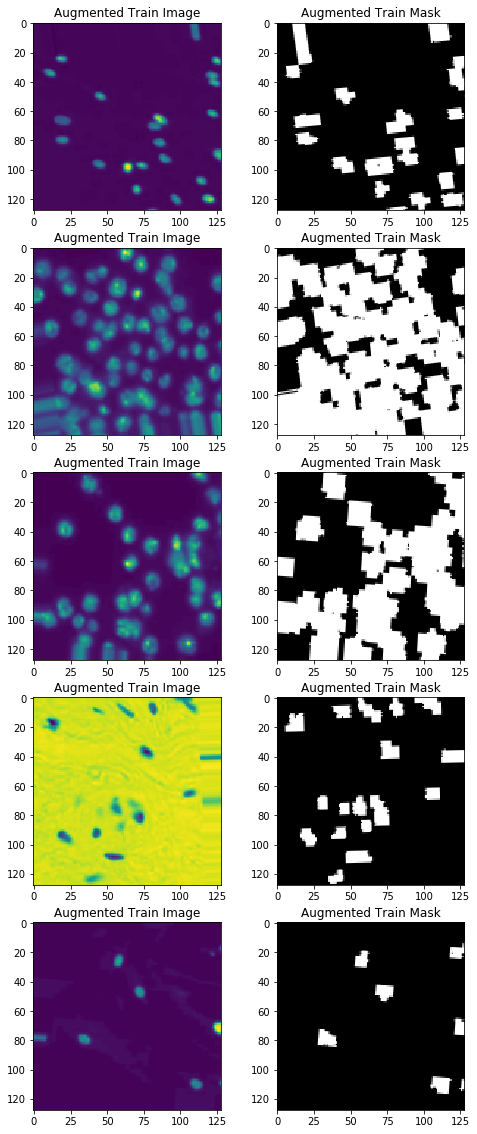

Building U-Net...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
____________________________________________________________________________

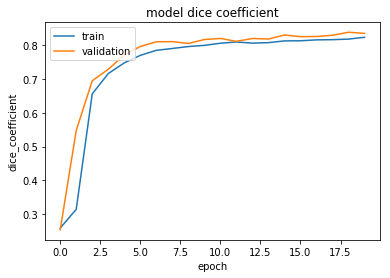

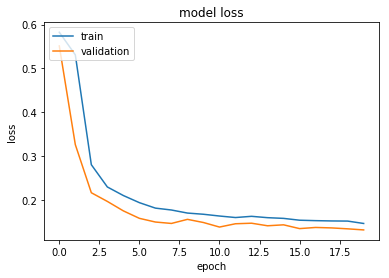

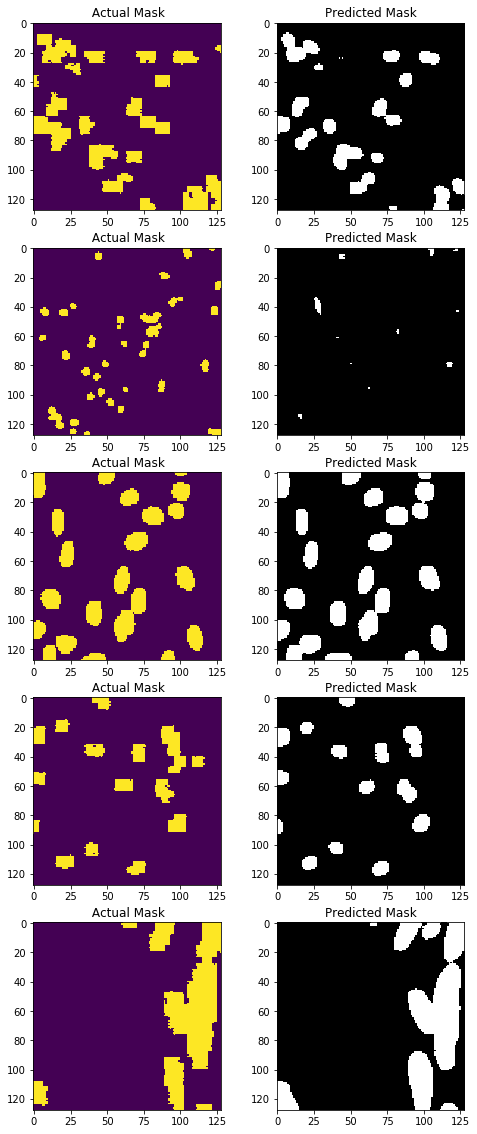

Generating mask for test data...
Resizing generated masks to actual dimensions...
Complete...


In [13]:
if __name__=='__main__':
    x_data,y_data = imageProcessingModule()
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1)
    augmentedImageChecker(x_train, y_train, 5)
    model, history = modelBuilder(x_train, x_val, y_train, y_val)
    plot_model_history(history)
    validationImageChecker(x_val,y_val)
    testingModule()